In [1]:
import scanpy as sc
import numpy as np
import pandas as pd
from scipy.stats import median_abs_deviation as mad
import os

In [2]:
# importamos directamente SoupX

import anndata2ri
import logging
import rpy2.rinterface_lib.callbacks as rcb
import rpy2.robjects as ro
from rpy2.robjects.packages import importr
from rpy2.robjects.conversion import localconverter


# Desactivar los logs de rpy2 para evitar warnings
rcb.logger.setLevel(logging.ERROR)

# Activar la conversión de pandas y AnnData a R
ro.pandas2ri.activate()
anndata2ri.activate()

# Cargar SoupX directamente en Python usando rpy2
try:
    soupx = importr("SoupX")
    print("SoupX loaded successfully!")
except Exception as e:
    print(f"Error loading SoupX: {e}")

# Opcional: si prefieres seguir usando las celdas mágicas, asegúrate de que la extensión esté cargada
%load_ext rpy2.ipython

/home/evercher/tmpdir/ipykernel_37667/350021673.py:16: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  anndata2ri.activate()



    an issue that caused a segfault when used with rpy2:
    https://github.com/rstudio/reticulate/pull/1188
    Make sure that you use a version of that package that includes
    the fix.
SoupX loaded successfully!


En el tutorial cargan el objeto Anndata directamente.
En este caso, se cargará el objeto Anndata desde un archivo .h5ad que ya ha sido eliminadas las células de calidad baja.

In [3]:
# Función para identificar outliers usando MAD (Median Absolute Deviation)
def mad_outlier(adata, metric, nmads):
    M = adata.obs[metric]
    return (M < np.median(M) - nmads * mad(M)) | (M > np.median(M) + nmads * mad(M))

# Función para procesar y aplicar el filtrado QC
def pp(adata):
    # Calcular las métricas QC
    adata.var["mt"] = adata.var_names.str.startswith("MT-")
    sc.pp.calculate_qc_metrics(adata, qc_vars=["mt"], 
                               inplace=True, percent_top=[20], log1p=True)
    
    # Filtrar outliers
    bool_vector = mad_outlier(adata, 'log1p_total_counts', 5) + \
                  mad_outlier(adata, 'log1p_n_genes_by_counts', 5) + \
                  mad_outlier(adata, 'pct_counts_in_top_20_genes', 5) + \
                  mad_outlier(adata, 'pct_counts_mt', 3)
    
    adata = adata[~bool_vector]
    
    return adata

In [5]:

# Cargar las matrices filtradas de los pacientes humanos
pt_14_filtered = sc.read_h5ad("/data/scratch/LAB/enric/Proyecto_pitagoras/Analisis_pitagoras/Results/01_filtered_matrices/PT_14_filtered.h5ad")
pt_17_filtered = sc.read_h5ad("/data/scratch/LAB/enric/Proyecto_pitagoras/Analisis_pitagoras/Results/01_filtered_matrices/PT_17_filtered.h5ad")
pt_20_filtered = sc.read_h5ad("/data/scratch/LAB/enric/Proyecto_pitagoras/Analisis_pitagoras/Results/01_filtered_matrices/PT_20_filtered.h5ad")
pt_22_filtered = sc.read_h5ad("/data/scratch/LAB/enric/Proyecto_pitagoras/Analisis_pitagoras/Results/01_filtered_matrices/PT_22_filtered.h5ad")
pt_28_filtered = sc.read_h5ad("/data/scratch/LAB/enric/Proyecto_pitagoras/Analisis_pitagoras/Results/01_filtered_matrices/PT_28_filtered.h5ad")

# Aplicar el filtrado QC a las matrices de los pacientes humanos
pt_14_filtered = pp(pt_14_filtered)
pt_17_filtered = pp(pt_17_filtered)
pt_20_filtered = pp(pt_20_filtered)
pt_22_filtered = pp(pt_22_filtered)
pt_28_filtered = pp(pt_28_filtered)

In [6]:
# Cargar las matrices filtradas de los nuevos pacientes
pt_18_filtered = sc.read_h5ad("/data/scratch/LAB/enric/Proyecto_pitagoras/Analisis_pitagoras/Results/01_filtered_matrices/PT_18_filtered.h5ad")
pt_41_filtered = sc.read_h5ad("/data/scratch/LAB/enric/Proyecto_pitagoras/Analisis_pitagoras/Results/01_filtered_matrices/PT_41_filtered.h5ad")
pt14_pan_filtered = sc.read_h5ad("/data/scratch/LAB/enric/Proyecto_pitagoras/Analisis_pitagoras/Results/01_filtered_matrices/PT14_pan_filtered.h5ad")
pt_49_filtered = sc.read_h5ad("/data/scratch/LAB/enric/Proyecto_pitagoras/Analisis_pitagoras/Results/01_filtered_matrices/PT_49_filtered.h5ad")
pt_50_filtered = sc.read_h5ad("/data/scratch/LAB/enric/Proyecto_pitagoras/Analisis_pitagoras/Results/01_filtered_matrices/PT_50_filtered.h5ad")

# Aplicar el filtrado QC a las matrices de los nuevos pacientes
pt_18_filtered = pp(pt_18_filtered)
pt_41_filtered = pp(pt_41_filtered)
pt14_pan_filtered = pp(pt14_pan_filtered)
pt_49_filtered = pp(pt_49_filtered)
pt_50_filtered = pp(pt_50_filtered)

In [7]:
# Función para obtener los clusters para SoupX
def get_soupx_group(adata):
    adata_pp = adata.copy()
    sc.pp.normalize_per_cell(adata_pp)  # Normalización por célula
    sc.pp.log1p(adata_pp)  # Logaritmo natural de los datos
    sc.pp.pca(adata_pp)  # Análisis de componentes principales (PCA)
    sc.pp.neighbors(adata_pp)  # Calcular vecinos
    sc.tl.leiden(adata_pp, key_added="soupx_groups")  # Agrupamiento Leiden
    return adata_pp.obs['soupx_groups']

# Función para preparar los datos para SoupX sin la intersección de genes
def prepare_broth(adata, raw_data_path):
    # Nombres de células y genes
    cells = adata.obs_names
    genes_filtered = adata.var_names

    data = adata.X.T  # Transponer los datos para SoupX

    # Cargar los datos raw
    adata_raw = sc.read_h5ad(raw_data_path)
    
    # Asegurar que los nombres de las variables (genes) sean únicos
    adata_raw.var_names_make_unique()

    # Extraer los datos crudos transpuestos
    raw = adata_raw.X.T

    # Obtener los clusters de SoupX
    soupx_groups = get_soupx_group(adata)

    return data, raw, genes_filtered, cells, soupx_groups

In [ ]:
# Función para aplicar SoupX a los datos
def cook_soup(adata, raw_data_path):
    data, raw, genes, cells, soupx_groups = prepare_broth(adata, raw_data_path)

    # Usar `localconverter` para pasar los objetos de Python a R y viceversa
    with localconverter(anndata2ri.converter):
        ro.globalenv['data'] = data
        ro.globalenv['raw'] = raw
        ro.globalenv['genes'] = genes
        ro.globalenv['cells'] = cells
        ro.globalenv['soupx_groups'] = soupx_groups

        # Ejecutar código R para aplicar SoupX
        ro.r('''
            library(SoupX)
            make_soup <- function(data, raw, genes, cells, soupx_groups){
                rownames(data) = genes
                colnames(data) = cells
                data <- as(data, "sparseMatrix")
                raw <- as(raw, "sparseMatrix")
                sc = SoupChannel(raw, data, calcSoupProfile = FALSE)
                soupProf = data.frame(row.names = rownames(data), est = rowSums(data)/sum(data), counts = rowSums(data))
                sc = setSoupProfile(sc, soupProf)
                sc = setClusters(sc, soupx_groups)
                sc = autoEstCont(sc, doPlot=FALSE)
                out = adjustCounts(sc, roundToInt = TRUE)
                return(out)
            }
            out <- make_soup(data, raw, genes, cells, soupx_groups)
        ''')

        # Recuperar la matriz corregida
        out = ro.globalenv['out']

    # Guardar las capas de cuentas corregidas en AnnData
    adata = adata.copy()  # Hacer una copia explícita del objeto
    adata.layers["raw_counts"] = adata.X
    adata.layers["soupX_counts"] = out.T
    adata.X = adata.layers["soupX_counts"]

    # Mostrar el número total de genes antes del filtrado
    print(f"Total number of genes: {adata.n_vars}")

    # Mostrar el número de genes después del filtrado
    print(f"Number of genes after cell filter: {adata.n_vars}")

    return adata

# Definir las rutas de los datos raw y los nombres de las muestras humanas
raw_data_paths = {
    "PT_14": "/data/scratch/LAB/enric/Proyecto_pitagoras/Analisis_pitagoras/Results/00_raw_matrices/PT_14-final_2_raw.h5ad",
    "PT_17": "/data/scratch/LAB/enric/Proyecto_pitagoras/Analisis_pitagoras/Results/00_raw_matrices/PT_17-final_2_raw.h5ad",
    "PT_20": "/data/scratch/LAB/enric/Proyecto_pitagoras/Analisis_pitagoras/Results/00_raw_matrices/PT_20-final_2_raw.h5ad",
    "PT_22": "/data/scratch/LAB/enric/Proyecto_pitagoras/Analisis_pitagoras/Results/00_raw_matrices/PT_22-final_2_raw.h5ad",
    "PT_28": "/data/scratch/LAB/enric/Proyecto_pitagoras/Analisis_pitagoras/Results/00_raw_matrices/PT_28-final_2_raw.h5ad"
}

# Usar las matrices filtradas ya cargadas en memoria (no hace falta cargarlas de nuevo)
adata_list = {
    "PT_14": pt_14_filtered,  # Objeto AnnData que ya está en memoria
    "PT_17": pt_17_filtered,  # Objeto AnnData que ya está en memoria
    "PT_20": pt_20_filtered,  # Objeto AnnData que ya está en memoria
    "PT_22": pt_22_filtered,  # Objeto AnnData que ya está en memoria
    "PT_28": pt_28_filtered   # Objeto AnnData que ya está en memoria
}

# Aplicar SoupX a cada muestra
for sample, adata in adata_list.items():
    adata_list[sample] = cook_soup(adata, raw_data_paths[sample])

# Guardar las matrices corregidas en un archivo h5ad
output_dir = "/data/scratch/LAB/enric/Proyecto_pitagoras/Analisis_pitagoras/01_matrices_corregidas_SoupX"
os.makedirs(output_dir, exist_ok=True)

for sample, adata in adata_list.items():
    adata.write_h5ad(f"{output_dir}/{sample}_corrected_SoupX.h5ad")

### Lo mismo aplicado a los 5 nuevos pacientes

In [12]:
# Función para aplicar SoupX a los datos
def cook_soup(adata, raw_data_path):
    data, raw, genes, cells, soupx_groups = prepare_broth(adata, raw_data_path)

    # Usar `localconverter` para pasar los objetos de Python a R y viceversa
    with localconverter(anndata2ri.converter):
        ro.globalenv['data'] = data
        ro.globalenv['raw'] = raw
        ro.globalenv['genes'] = genes
        ro.globalenv['cells'] = cells
        ro.globalenv['soupx_groups'] = soupx_groups

        # Ejecutar código R para aplicar SoupX
        ro.r('''
            library(SoupX)
            make_soup <- function(data, raw, genes, cells, soupx_groups){
                rownames(data) = genes
                colnames(data) = cells
                data <- as(data, "sparseMatrix")
                raw <- as(raw, "sparseMatrix")
                sc = SoupChannel(raw, data, calcSoupProfile = FALSE)
                soupProf = data.frame(row.names = rownames(data), est = rowSums(data)/sum(data), counts = rowSums(data))
                sc = setSoupProfile(sc, soupProf)
                sc = setClusters(sc, soupx_groups)
                sc = autoEstCont(sc, doPlot=FALSE)
                out = adjustCounts(sc, roundToInt = TRUE)
                return(out)
            }
            out <- make_soup(data, raw, genes, cells, soupx_groups)
        ''')

        # Recuperar la matriz corregida
        out = ro.globalenv['out']

    # Guardar las capas de cuentas corregidas en AnnData
    adata = adata.copy()  # Hacer una copia explícita del objeto
    adata.layers["raw_counts"] = adata.X
    adata.layers["soupX_counts"] = out.T
    adata.X = adata.layers["soupX_counts"]

    # Mostrar el número total de genes antes del filtrado
    print(f"Total number of genes: {adata.n_vars}")

    # Mostrar el número de genes después del filtrado
    print(f"Number of genes after cell filter: {adata.n_vars}")

    return adata

# Definir las rutas de los datos raw para los nuevos pacientes
raw_data_paths_new = {
    "PT_18": "/data/scratch/LAB/enric/Proyecto_pitagoras/Analisis_pitagoras/Results/raw_matrices/PIT_18-final_raw.h5ad",
    "PT14_pan": "/data/scratch/LAB/enric/Proyecto_pitagoras/Analisis_pitagoras/Results/raw_matrices/P14-pancreas_raw.h5ad",
    "PT_41": "/data/scratch/LAB/enric/Proyecto_pitagoras/Analisis_pitagoras/Results/raw_matrices/PIT_41-final_raw.h5ad",
    "PT_49": "/data/scratch/LAB/enric/Proyecto_pitagoras/Analisis_pitagoras/Results/raw_matrices/PT_49-final_raw.h5ad",
    "PT_50": "/data/scratch/LAB/enric/Proyecto_pitagoras/Analisis_pitagoras/Results/raw_matrices/PT_50-final_raw.h5ad"
}

# Usar las matrices filtradas ya cargadas en memoria
adata_list_new = {
    "PT_18": pt_18_filtered,
    "PT14_pan": pt14_pan_filtered,
    "PT_41": pt_41_filtered,
    "PT_49": pt_49_filtered,
    "PT_50": pt_50_filtered
}

# Aplicar SoupX a cada muestra de los nuevos pacientes
for sample, adata in adata_list_new.items():
    adata_list_new[sample] = cook_soup(adata, raw_data_paths_new[sample])

# Guardar las matrices corregidas en un archivo h5ad
output_dir = "/data/scratch/LAB/enric/Proyecto_pitagoras/Analisis_pitagoras/01_matrices_corregidas_SoupX"
os.makedirs(output_dir, exist_ok=True)

for sample, adata in adata_list_new.items():
    adata.write_h5ad(f"{output_dir}/{sample}_corrected_SoupX.h5ad")

Total number of genes: 38606
Number of genes after cell filter: 38606
Total number of genes: 38606
Number of genes after cell filter: 38606
Total number of genes: 38606
Number of genes after cell filter: 38606
Total number of genes: 38606
Number of genes after cell filter: 38606
Total number of genes: 38606
Number of genes after cell filter: 38606


# Simple normalization and integration just for visualizaiton

In [10]:
import scanorama
from matplotlib.pyplot import rc_context

In [19]:
# Definir las rutas de los archivos corregidos con SoupX
corrected_files = {
    "PT_14": "/data/scratch/LAB/enric/Proyecto_pitagoras/Analisis_pitagoras/Results/01_matrices_corregidas_SoupX/PT_14_corrected_SoupX.h5ad",
    "PT_17": "/data/scratch/LAB/enric/Proyecto_pitagoras/Analisis_pitagoras/Results/01_matrices_corregidas_SoupX/PT_17_corrected_SoupX.h5ad",
    "PT_20": "/data/scratch/LAB/enric/Proyecto_pitagoras/Analisis_pitagoras/Results/01_matrices_corregidas_SoupX/PT_20_corrected_SoupX.h5ad",
    "PT_22": "/data/scratch/LAB/enric/Proyecto_pitagoras/Analisis_pitagoras/Results/01_matrices_corregidas_SoupX/PT_22_corrected_SoupX.h5ad",
    "PT_28": "/data/scratch/LAB/enric/Proyecto_pitagoras/Analisis_pitagoras/Results/01_matrices_corregidas_SoupX/PT_28_corrected_SoupX.h5ad"
}

# Cargar las matrices corregidas en una lista
corrected_adata_list = [sc.read_h5ad(file) for file in corrected_files.values()]

# O también puedes usar un diccionario si prefieres tener los nombres de los pacientes como clave
corrected_adata_dict = {patient: sc.read_h5ad(file) for patient, file in corrected_files.items()}

# Visualización rápida de la lista
for patient, adata in corrected_adata_dict.items():
    print(f"Paciente: {patient}, Número de genes: {adata.n_vars}, Número de células: {adata.n_obs}")


Paciente: PT_14, Número de genes: 38606, Número de células: 6634
Paciente: PT_17, Número de genes: 38606, Número de células: 6801
Paciente: PT_20, Número de genes: 38606, Número de células: 6566
Paciente: PT_22, Número de genes: 38606, Número de células: 7097
Paciente: PT_28, Número de genes: 38606, Número de células: 7502


In [39]:
# Definir las rutas de los archivos corregidos con SoupX para los nuevos pacientes
corrected_files_new = {
    "PT_18": "/data/scratch/LAB/enric/Proyecto_pitagoras/Analisis_pitagoras/Results/01_matrices_corregidas_SoupX/PT_18_corrected_SoupX.h5ad",
    "PT14_pan": "/data/scratch/LAB/enric/Proyecto_pitagoras/Analisis_pitagoras/Results/01_matrices_corregidas_SoupX/PT14_pan_corrected_SoupX.h5ad",
    "PT_41": "/data/scratch/LAB/enric/Proyecto_pitagoras/Analisis_pitagoras/Results/01_matrices_corregidas_SoupX/PT_41_corrected_SoupX.h5ad",
    "PT_49": "/data/scratch/LAB/enric/Proyecto_pitagoras/Analisis_pitagoras/Results/01_matrices_corregidas_SoupX/PT_49_corrected_SoupX.h5ad",
    "PT_50": "/data/scratch/LAB/enric/Proyecto_pitagoras/Analisis_pitagoras/Results/01_matrices_corregidas_SoupX/PT_50_corrected_SoupX.h5ad"
}

# Cargar las matrices corregidas en una lista
corrected_adata_list_new = [sc.read_h5ad(file) for file in corrected_files_new.values()]

# O también puedes usar un diccionario si prefieres tener los nombres de los pacientes como clave
corrected_adata_dict_new = {patient: sc.read_h5ad(file) for patient, file in corrected_files_new.items()}

# Visualización rápida de la lista
for patient, adata in corrected_adata_dict_new.items():
    print(f"Paciente: {patient}, Número de genes: {adata.n_vars}, Número de células: {adata.n_obs}")


Paciente: PT_18, Número de genes: 38606, Número de células: 1143
Paciente: PT14_pan, Número de genes: 38606, Número de células: 1788
Paciente: PT_41, Número de genes: 38606, Número de células: 5773
Paciente: PT_49, Número de genes: 38606, Número de células: 8419
Paciente: PT_50, Número de genes: 38606, Número de células: 7447


In [40]:
adata_pt18 = corrected_adata_list_new[0]
adata_pt18

AnnData object with n_obs × n_vars = 1143 × 38606
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    layers: 'raw_counts', 'soupX_counts'

In [22]:
# Verificar si 'soupX_counts' está normalizado
import numpy as np

# Extraer la capa 'soupX_counts'
soupX_counts = adata_pt18.layers["soupX_counts"]

# Suma total por celda
cell_sums = np.sum(soupX_counts, axis=1)

# Mostrar algunas estadísticas
print("Estadísticas de las sumas por celda en 'soupX_counts':")
print(f"Mínimo: {cell_sums.min()}")
print(f"Máximo: {cell_sums.max()}")
print(f"Media: {cell_sums.mean()}")

# Mostrar ejemplos de cuentas por celda
print("Ejemplos de sumas totales por celda:")
print(cell_sums[:10])


Estadísticas de las sumas por celda en 'soupX_counts':
Mínimo: 792.0
Máximo: 8942.0
Media: 2974.9930008748906
Ejemplos de sumas totales por celda:
[[ 811.]
 [2803.]
 [ 830.]
 [1045.]
 [2690.]
 [3219.]
 [1660.]
 [1564.]
 [4247.]
 [3335.]]


In [23]:
for i, adata in enumerate(corrected_adata_list_new):
    print(f"Paciente {i + 1}: CD4 presente: {'CD4' in adata.var_names}")
    print(f"Paciente {i + 1}: CD8A presente: {'CD8A' in adata.var_names}")

Paciente 1: CD4 presente: True
Paciente 1: CD8A presente: True
Paciente 2: CD4 presente: True
Paciente 2: CD8A presente: True
Paciente 3: CD4 presente: True
Paciente 3: CD8A presente: True
Paciente 4: CD4 presente: True
Paciente 4: CD8A presente: True
Paciente 5: CD4 presente: True
Paciente 5: CD8A presente: True


LA CAPA RAW_COUNTS SON LOS CONTEOS CRUDOS ORIGINALES (SIN NORMALIZAR NI NADA) Y  soupX_counts los conteos crudos corregidos (sin normalizar ni nada)

In [24]:
# Calcular las proporciones de conteos corregidos para cada paciente
proportions = []
for patient, adata in corrected_adata_dict.items():
    raw_counts = adata.layers["raw_counts"].sum()
    soupX_counts = adata.layers["soupX_counts"].sum()
    corrected_prop = (raw_counts - soupX_counts) / raw_counts
    proportions.append(corrected_prop)
patients = ["PT_14", "PT_17", "PT_20", "PT_22", "PT_28"]
for i, prop in enumerate(proportions):
    print(f"Porcentaje de conteos corregidos en {patients[i]}: {prop * 100:.2f}%")


Porcentaje de conteos corregidos en PT_14: 3.80%
Porcentaje de conteos corregidos en PT_17: 2.10%
Porcentaje de conteos corregidos en PT_20: 1.00%
Porcentaje de conteos corregidos en PT_22: 1.10%
Porcentaje de conteos corregidos en PT_28: 1.00%


In [25]:
# Calcular las proporciones de conteos corregidos para los nuevos pacientes
proportions_new = []
for patient, adata in corrected_adata_dict_new.items():
    raw_counts = adata.layers["raw_counts"].sum()
    soupX_counts = adata.layers["soupX_counts"].sum()
    corrected_prop = (raw_counts - soupX_counts) / raw_counts
    proportions_new.append(corrected_prop)

# Pacientes nuevos
patients_new = ["PT_18", "PT14_pan", "PT_41", "PT_49", "PT_50"]

# Mostrar los porcentajes de conteos corregidos
for i, prop in enumerate(proportions_new):
    print(f"Porcentaje de conteos corregidos en {patients_new[i]}: {prop * 100:.2f}%")


Porcentaje de conteos corregidos en PT_18: 19.70%
Porcentaje de conteos corregidos en PT14_pan: 1.00%
Porcentaje de conteos corregidos en PT_41: 2.80%
Porcentaje de conteos corregidos en PT_49: 1.10%
Porcentaje de conteos corregidos en PT_50: 1.70%


In [64]:
import pandas as pd

# Calcular la cantidad absoluta de UMIs eliminados en cada muestra
umi_reduction = []
total_raw_counts = []
total_soupx_counts = []

for patient, adata in corrected_adata_dict_new.items():
    raw_counts = adata.layers["raw_counts"].sum()
    soupX_counts = adata.layers["soupX_counts"].sum()
    
    # Cantidad absoluta de UMIs eliminados
    absolute_reduction = raw_counts - soupX_counts
    
    umi_reduction.append(absolute_reduction)
    total_raw_counts.append(raw_counts)
    total_soupx_counts.append(soupX_counts)

# Crear tabla con los resultados
patients_new = ["PT_18", "PT14_pan", "PT_41", "PT_49", "PT_50"]
umi_reduction_df = pd.DataFrame({
    "Paciente": patients_new,
    "Total Raw UMIs": total_raw_counts,
    "Total SoupX UMIs": total_soupx_counts,
    "Absolute Reduction (UMIs)": umi_reduction
})

# Mostrar la tabla
print("Cantidad absoluta de UMIs eliminados por SoupX:")
umi_reduction_df


Cantidad absoluta de UMIs eliminados por SoupX:


,Paciente,Total Raw UMIs,Total SoupX UMIs,Absolute Reduction (UMIs)
0,PT_18,4234772.0,3400417.0,834355.0
1,PT14_pan,7978857.0,7899033.0,79824.0
2,PT_41,31124244.0,30252514.0,871730.0
3,PT_49,40483088.0,40038098.0,444990.0
4,PT_50,39043800.0,38379283.0,664517.0


In [66]:
# Calcular el porcentaje de corrección total (UMIs eliminados / UMIs totales antes de SoupX)
umi_reduction_df["Correction Percentage (%)"] = (umi_reduction_df["Absolute Reduction (UMIs)"] / umi_reduction_df["Total Raw UMIs"]) * 100

# Calcular la tasa de contaminación inicial (UMIs eliminados / UMIs después de SoupX)
umi_reduction_df["Initial Contamination Rate (%)"] = (umi_reduction_df["Absolute Reduction (UMIs)"] / umi_reduction_df["Total SoupX UMIs"]) * 100

# Mostrar la tabla con las nuevas métricas
print("Tabla con porcentaje de corrección y tasa de contaminación inicial:")
umi_reduction_df


Tabla con porcentaje de corrección y tasa de contaminación inicial:


,Paciente,Total Raw UMIs,Total SoupX UMIs,Absolute Reduction (UMIs),Correction Percentage (%),Initial Contamination Rate (%)
0,PT_18,4234772.0,3400417.0,834355.0,19.702477,24.536844
1,PT14_pan,7978857.0,7899033.0,79824.0,1.000444,1.010554
2,PT_41,31124244.0,30252514.0,871730.0,2.800807,2.881513
3,PT_49,40483088.0,40038098.0,444990.0,1.099200,1.111416
4,PT_50,39043800.0,38379283.0,664517.0,1.701978,1.731447


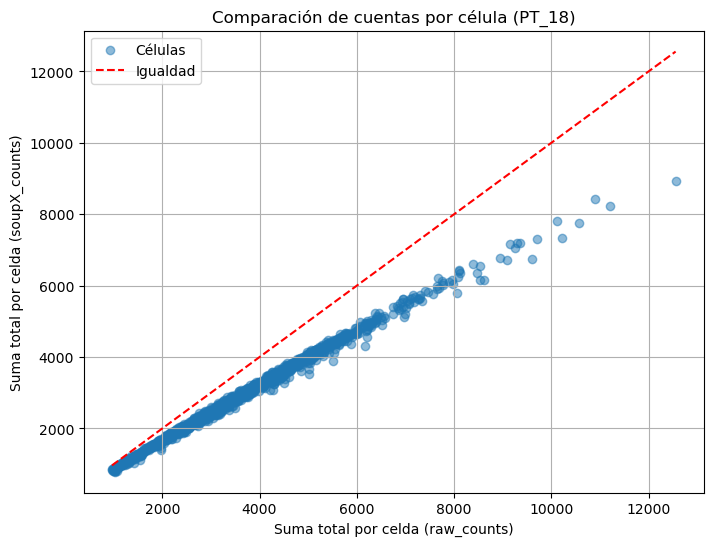

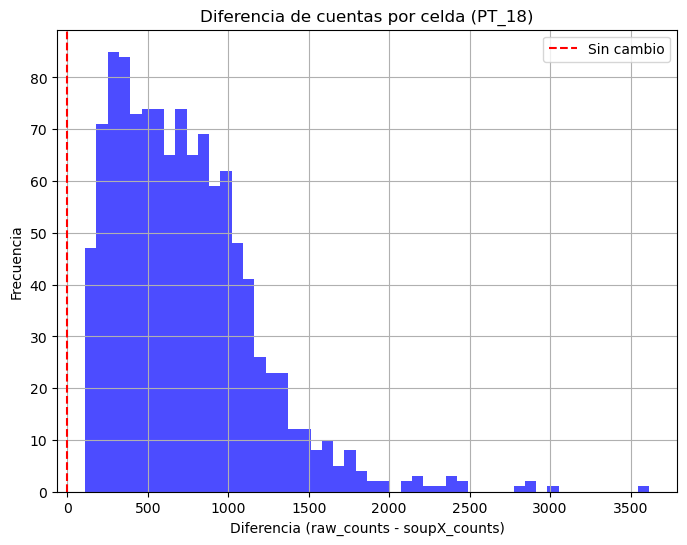

Top 10 genes con mayores correcciones:
MALAT1: -27834.0
HSPA1A: -12266.0
EEF1A1: -7681.0
RPL41: -7008.0
B2M: -6824.0
RPS27: -6429.0
HSPA6: -6278.0
RPLP1: -6019.0
HSPA1B: -5335.0
RPS12: -5259.0


In [26]:
import matplotlib.pyplot as plt
import numpy as np

# Extraer el objeto AnnData para PT_18
adata_pt18 = corrected_adata_dict_new["PT_18"]

# Comparar las sumas totales por celda entre 'raw_counts' y 'soupX_counts'
raw_counts = np.sum(adata_pt18.layers["raw_counts"], axis=1).A1  # Convertir a vector 1D
soupX_counts = np.sum(adata_pt18.layers["soupX_counts"], axis=1).A1  # Convertir a vector 1D

# Gráfico de comparación de sumas totales por celda
plt.figure(figsize=(8, 6))
plt.scatter(raw_counts, soupX_counts, alpha=0.5, label="Células")
plt.plot([raw_counts.min(), raw_counts.max()], [raw_counts.min(), raw_counts.max()], 'r--', label="Igualdad")
plt.xlabel("Suma total por celda (raw_counts)")
plt.ylabel("Suma total por celda (soupX_counts)")
plt.title("Comparación de cuentas por célula (PT_18)")
plt.legend()
plt.grid(True)
plt.show()

# Histograma de las diferencias entre 'raw_counts' y 'soupX_counts'
differences = raw_counts - soupX_counts
plt.figure(figsize=(8, 6))
plt.hist(differences, bins=50, color="blue", alpha=0.7)
plt.axvline(x=0, color="red", linestyle="--", label="Sin cambio")
plt.xlabel("Diferencia (raw_counts - soupX_counts)")
plt.ylabel("Frecuencia")
plt.title("Diferencia de cuentas por celda (PT_18)")
plt.legend()
plt.grid(True)
plt.show()

# Identificar los genes con mayores cambios
raw_gene_sums = np.sum(adata_pt18.layers["raw_counts"], axis=0).A1  # Convertir a vector 1D
soupX_gene_sums = np.sum(adata_pt18.layers["soupX_counts"], axis=0).A1  # Convertir a vector 1D
gene_differences = raw_gene_sums - soupX_gene_sums

# Obtener los nombres de los genes más afectados
genes_affected = adata_pt18.var_names[np.argsort(-gene_differences)[:10]]  # Top 10 genes con mayor diferencia
print("Top 10 genes con mayores correcciones:")
for gene, diff in zip(genes_affected, np.sort(-gene_differences)[:10]):
    print(f"{gene}: {diff}")


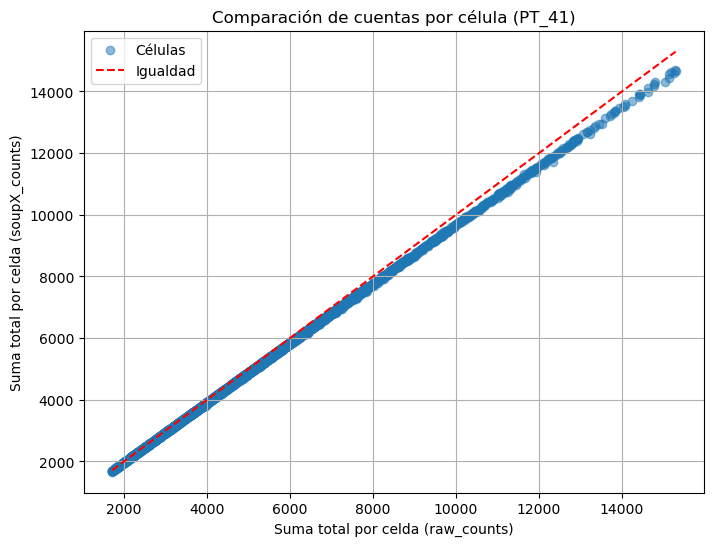

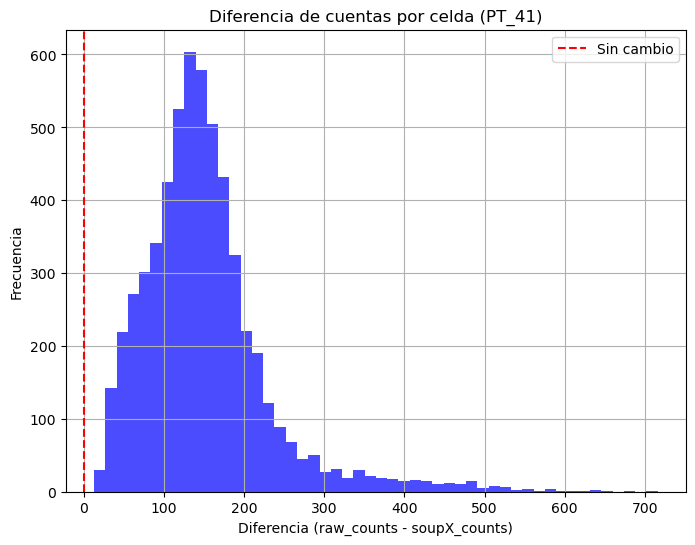

Top 10 genes con mayores correcciones:
MALAT1: -17564.0
EEF1A1: -10797.0
RPLP1: -10746.0
B2M: -10484.0
TMSB4X: -9637.0
RPL41: -8756.0
TPT1: -7247.0
RPL10: -6780.0
RPS27: -6727.0
RPS19: -6547.0


In [12]:
import matplotlib.pyplot as plt
import numpy as np

# Extraer el objeto AnnData para PT_41
adata_pt41 = corrected_adata_dict_new["PT_41"]

# Comparar las sumas totales por celda entre 'raw_counts' y 'soupX_counts'
raw_counts = np.sum(adata_pt41.layers["raw_counts"], axis=1).A1  # Convertir a vector 1D
soupX_counts = np.sum(adata_pt41.layers["soupX_counts"], axis=1).A1  # Convertir a vector 1D

# Gráfico de comparación de sumas totales por celda
plt.figure(figsize=(8, 6))
plt.scatter(raw_counts, soupX_counts, alpha=0.5, label="Células")
plt.plot([raw_counts.min(), raw_counts.max()], [raw_counts.min(), raw_counts.max()], 'r--', label="Igualdad")
plt.xlabel("Suma total por celda (raw_counts)")
plt.ylabel("Suma total por celda (soupX_counts)")
plt.title("Comparación de cuentas por célula (PT_41)")
plt.legend()
plt.grid(True)
plt.show()

# Histograma de las diferencias entre 'raw_counts' y 'soupX_counts'
differences = raw_counts - soupX_counts
plt.figure(figsize=(8, 6))
plt.hist(differences, bins=50, color="blue", alpha=0.7)
plt.axvline(x=0, color="red", linestyle="--", label="Sin cambio")
plt.xlabel("Diferencia (raw_counts - soupX_counts)")
plt.ylabel("Frecuencia")
plt.title("Diferencia de cuentas por celda (PT_41)")
plt.legend()
plt.grid(True)
plt.show()

# Identificar los genes con mayores cambios
raw_gene_sums = np.sum(adata_pt41.layers["raw_counts"], axis=0).A1  # Convertir a vector 1D
soupX_gene_sums = np.sum(adata_pt41.layers["soupX_counts"], axis=0).A1  # Convertir a vector 1D
gene_differences = raw_gene_sums - soupX_gene_sums

# Obtener los nombres de los genes más afectados
genes_affected = adata_pt41.var_names[np.argsort(-gene_differences)[:10]]  # Top 10 genes con mayor diferencia
print("Top 10 genes con mayores correcciones:")
for gene, diff in zip(genes_affected, np.sort(-gene_differences)[:10]):
    print(f"{gene}: {diff}")


Antiguos pacientes:

In [30]:
# Función para normalizar y seleccionar genes altamente variables
def norm_for_integration(adata):
    # Normalizar y aplicar log1p
    sc.pp.filter_genes(adata, min_cells=1, inplace=True)
    sc.pp.normalize_total(adata, inplace=True)
    sc.pp.log1p(adata)

    # Seleccionar genes altamente variables
    sc.pp.highly_variable_genes(adata, flavor="seurat", n_top_genes=4000, inplace=True, subset=True)
    
    return adata

# Lista con los nombres de los archivos corregidos (muestras humanas)
file_paths = [
    "/data/scratch/LAB/enric/Proyecto_pitagoras/Analisis_pitagoras/Results/01_matrices_corregidas_SoupX/PT_14_corrected_SoupX.h5ad",
    "/data/scratch/LAB/enric/Proyecto_pitagoras/Analisis_pitagoras/Results/01_matrices_corregidas_SoupX/PT_17_corrected_SoupX.h5ad",
    "/data/scratch/LAB/enric/Proyecto_pitagoras/Analisis_pitagoras/Results/01_matrices_corregidas_SoupX/PT_20_corrected_SoupX.h5ad",
    "/data/scratch/LAB/enric/Proyecto_pitagoras/Analisis_pitagoras/Results/01_matrices_corregidas_SoupX/PT_22_corrected_SoupX.h5ad",
    "/data/scratch/LAB/enric/Proyecto_pitagoras/Analisis_pitagoras/Results/01_matrices_corregidas_SoupX/PT_28_corrected_SoupX.h5ad"
]

# Cargar cada muestra humana y aplicar normalización para integración
adatas = [sc.read_h5ad(file) for file in file_paths]
norm_adatas = [norm_for_integration(adata.copy()) for adata in adatas]


NUEVOS PACIENTES:

In [27]:
# Función para normalizar y seleccionar genes altamente variables
def norm_for_integration(adata):
    # Normalizar y aplicar log1p
    sc.pp.filter_genes(adata, min_cells=1, inplace=True)  # Filtrar genes detectados en al menos 1 célula
    sc.pp.normalize_total(adata, inplace=True)  # Normalizar cuentas totales por célula
    sc.pp.log1p(adata)  # Aplicar transformación logarítmica (log1p)

    # Seleccionar genes altamente variables
    sc.pp.highly_variable_genes(adata, flavor="seurat", n_top_genes=5000, inplace=True, subset=True)
    
    return adata

# Lista con los nombres de los archivos corregidos (nuevos pacientes)
file_paths_new = [
    "/data/scratch/LAB/enric/Proyecto_pitagoras/Analisis_pitagoras/Results/01_matrices_corregidas_SoupX/PT_18_corrected_SoupX.h5ad",
    "/data/scratch/LAB/enric/Proyecto_pitagoras/Analisis_pitagoras/Results/01_matrices_corregidas_SoupX/PT14_pan_corrected_SoupX.h5ad",
    "/data/scratch/LAB/enric/Proyecto_pitagoras/Analisis_pitagoras/Results/01_matrices_corregidas_SoupX/PT_41_corrected_SoupX.h5ad",
    "/data/scratch/LAB/enric/Proyecto_pitagoras/Analisis_pitagoras/Results/01_matrices_corregidas_SoupX/PT_49_corrected_SoupX.h5ad",
    "/data/scratch/LAB/enric/Proyecto_pitagoras/Analisis_pitagoras/Results/01_matrices_corregidas_SoupX/PT_50_corrected_SoupX.h5ad"
]

# Cargar cada muestra nueva y aplicar normalización para integración
adatas_new = [sc.read_h5ad(file) for file in file_paths_new]
norm_adatas_new = [norm_for_integration(adata.copy()) for adata in adatas_new]

# Verificar el resultado para cada paciente
for i, adata in enumerate(norm_adatas_new):
    print(f"Paciente {i + 1}:")
    print(f"  Número de células: {adata.n_obs}")
    print(f"  Número de genes seleccionados (altamente variables): {adata.n_vars}")


Paciente 1:
  Número de células: 1143
  Número de genes seleccionados (altamente variables): 5000
Paciente 2:
  Número de células: 1788
  Número de genes seleccionados (altamente variables): 5000
Paciente 3:
  Número de células: 5773
  Número de genes seleccionados (altamente variables): 5000
Paciente 4:
  Número de células: 8419
  Número de genes seleccionados (altamente variables): 5000
Paciente 5:
  Número de células: 7447
  Número de genes seleccionados (altamente variables): 5000


In [28]:
# Mostrar las capas de cada objeto en norm_adatas
for i, adata in enumerate(norm_adatas):
    print(f"Capas del paciente {i + 1}: {adata.layers.keys()}")

NameError: name 'norm_adatas' is not defined

In [21]:
# Integrar las muestras normalizadas con Scanorama
scanorama_int = scanorama.integrate_scanpy(norm_adatas)

# Extraer las embeddings integradas
scanorama_int = [adata.obsm['X_scanorama'] for adata in norm_adatas]  # Verificar que se almacenen correctamente

Found 948 genes among all datasets
[[0.         0.22423173 0.294694   0.45688875 0.27615315]
 [0.         0.         0.56107219 0.28422291 0.27054845]
 [0.         0.         0.         0.53990253 0.43572952]
 [0.         0.         0.         0.         0.42778639]
 [0.         0.         0.         0.         0.        ]]
Processing datasets (1, 2)
Processing datasets (2, 3)
Processing datasets (0, 3)
Processing datasets (2, 4)
Processing datasets (3, 4)
Processing datasets (0, 2)
Processing datasets (1, 3)
Processing datasets (0, 4)
Processing datasets (1, 4)
Processing datasets (0, 1)


NUEVOS PACIENTES:

In [31]:
# Integrar las muestras normalizadas con Scanorama
scanorama_int = scanorama.integrate_scanpy(norm_adatas_new)

# Extraer las embeddings integradas
scanorama_int = [adata.obsm['X_scanorama'] for adata in norm_adatas_new]  # Verificar que se almacenen correctamente

Found 824 genes among all datasets
[[0.         0.16498881 0.49693788 0.40332458 0.22922135]
 [0.         0.         0.59004474 0.45190157 0.48042506]
 [0.         0.         0.         0.69582539 0.67330677]
 [0.         0.         0.         0.         0.68591379]
 [0.         0.         0.         0.         0.        ]]
Processing datasets (2, 3)
Processing datasets (3, 4)
Processing datasets (2, 4)
Processing datasets (1, 2)
Processing datasets (0, 2)
Processing datasets (1, 4)
Processing datasets (1, 3)
Processing datasets (0, 3)
Processing datasets (0, 4)
Processing datasets (0, 1)


In [22]:
# Obtener las dimensiones de cada embedding en la lista scanorama_int
embedding_shapes = [embedding.shape for embedding in scanorama_int]
print(embedding_shapes)

[(6634, 100), (6801, 100), (6566, 100), (7097, 100), (7502, 100)]


In [ ]:
# Obtener las dimensiones de cada embedding en la lista scanorama_int
embedding_shapes_new = [embedding.shape for embedding in scanorama_int]
print("Dimensiones de las embeddings integradas para cada paciente:")
print(embedding_shapes_new)


In [23]:

# Combinar las muestras en un único objeto AnnData
adata = sc.concat(adatas, index_unique='_')

# Asegurarte de añadir las embeddings de Scanorama a los datos combinados
adata.obsm["X_scanorama"] = np.concatenate(scanorama_int, axis=0)  # Aquí concatenas correctamente las embeddings

# Ahora deberías poder calcular los vecinos usando la representación integrada
sc.pp.neighbors(adata, use_rep="X_scanorama")

# Calcular UMAP para la visualización
sc.tl.umap(adata)


NUEVOS PACIENTES:

In [32]:
# Obtener las dimensiones de cada embedding en la lista scanorama_int
embedding_shapes_new = [embedding.shape for embedding in scanorama_int]
print("Dimensiones de las embeddings integradas para cada paciente:")
print(embedding_shapes_new)

Dimensiones de las embeddings integradas para cada paciente:
[(1143, 100), (1788, 100), (5773, 100), (8419, 100), (7447, 100)]


In [33]:
# Combinar las muestras y agregar `batch`
adata_combined = sc.concat(
    adatas_new, 
    index_unique='_', 
    keys=["PT_18", "PT14_pan", "PT_41", "PT_49", "PT_50"],
    label="batch"
)

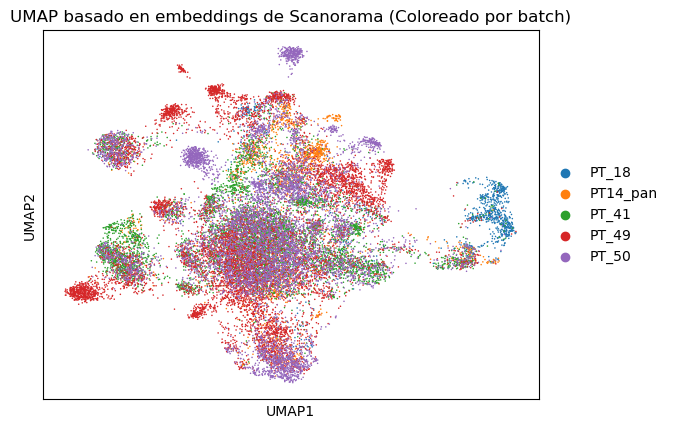

In [34]:

# Añadir las embeddings de Scanorama al objeto combinado
adata_combined.obsm["X_scanorama"] = np.concatenate(
    [adata.obsm["X_scanorama"] for adata in norm_adatas_new], axis=0
)

# Calcular los vecinos usando la representación integrada
sc.pp.neighbors(adata_combined, use_rep="X_scanorama")

# Calcular UMAP para la visualización
sc.tl.umap(adata_combined)

# Visualizar UMAP con color por `batch`
sc.pl.umap(adata_combined, color="batch", title="UMAP basado en embeddings de Scanorama (Coloreado por batch)")


Antiguos pacientes:

In [24]:
# Obtener las capas de datos antes y después de SoupX
before = adata.layers['raw_counts'].copy()
after = adata.layers['soupX_counts'].copy()

# Binarizar las matrices de conteos antes y después de SoupX
before.data = np.where(before.data > 0, 1, 0)
after.data = np.where(after.data > 0, 1, 0)

# Calcular la diferencia entre las matrices binarizadas
diff = before - after

# Crear una matriz binaria indicando dónde se ha eliminado el mRNA ambiental
changed = (diff == 1).astype(int)
adata.layers['changed'] = changed

# Guardar cuántas células han sido afectadas por gen
adata.var['soupX_removed'] = adata.layers['changed'].sum(axis=0).A1

# Ordenar los genes según el número de células en las que se eliminaron
adata.var.sort_values('soupX_removed', ascending=False)

,soupX_removed
GNLY,1269
CCL5,1043
S100A4,596
CXCL13,578
TALAM1,570
...,...
ENSG00000238009,0
OR4F5,0
ENSG00000290826,0
FAM138A,0


NUEVOS PACIENTES:

In [35]:
# Obtener las capas de datos antes y después de SoupX para el objeto combinado
before = adata_combined.layers['raw_counts'].copy()  # Cuentas originales
after = adata_combined.layers['soupX_counts'].copy()  # Cuentas corregidas por SoupX

# Binarizar las matrices de conteos antes y después de SoupX
before.data = np.where(before.data > 0, 1, 0)
after.data = np.where(after.data > 0, 1, 0)

# Calcular la diferencia entre las matrices binarizadas
diff = before - after

# Crear una matriz binaria indicando dónde se ha eliminado el mRNA ambiental
changed = (diff == 1).astype(int)
adata_combined.layers['changed'] = changed

# Guardar cuántas células han sido afectadas por gen
adata_combined.var['soupX_removed'] = adata_combined.layers['changed'].sum(axis=0).A1

# Ordenar los genes según el número de células en las que se eliminaron
genes_removed = adata_combined.var.sort_values('soupX_removed', ascending=False)

# Mostrar los genes más afectados
print("Genes más afectados por SoupX:")
print(genes_removed.head(10))

Genes más afectados por SoupX:
          soupX_removed
CCL5                868
GNLY                846
HSP90AA1            792
HSPA8               685
HSP90AB1            648
JUN                 582
TALAM1              573
SQSTM1              569
DNAJB1              560
HSPD1               551


In [34]:
# Mostrar las capas disponibles en el objeto AnnData
print(adata.layers.keys())

KeysView(Layers with keys: raw_counts, soupX_counts)


Antiguos pacientes:

In [ ]:
# Normalizar nuevamente los datos para visualización
sc.pp.normalize_total(adata, inplace=True)
sc.pp.log1p(adata)

In [ ]:
# Visualización de UMAP para los genes de interés
with rc_context({'figure.figsize': (4, 4)}):
    sc.pl.umap(adata, color=['CD4', 'CD8A'],vmax=3)

# Visualización con la capa de conteos 'raw_counts' con escala ajustada
with rc_context({'figure.figsize': (4, 4)}):
    sc.pl.umap(adata, color=['CD4', 'CD8A'], vmax=3, layer='raw_counts')

# Visualización con la capa de conteos 'soupX_counts' con escala ajustada
with rc_context({'figure.figsize': (4, 4)}):
    sc.pl.umap(adata, color=['CD4', 'CD8A'], vmax=3, layer='soupX_counts')

# UMAP específico para el gen 'Chil3'
with rc_context({'figure.figsize': (6, 6)}):
    sc.pl.umap(adata, color=['CD4'], vmax=1, layer='raw_counts', s=10, frameon=False, title='')

# La primera imagen usa los datos corregidos (post SoupX) con normalización y log-transformación estándar.
# La segunda imagen muestra los datos sin corrección (conteos crudos).
# La tercera imagen muestra los datos corregidos directamente usando SoupX, pero sin la transformación adicional.

NUEVOS PACIENTES:

In [36]:
from matplotlib import rc_context

# Normalizar nuevamente los datos combinados para visualización
sc.pp.normalize_total(adata_combined, inplace=True)
sc.pp.log1p(adata_combined)

In [ ]:

# Visualización de UMAP para los genes de interés ('CD4' y 'CD8A') en los datos normalizados
with rc_context({'figure.figsize': (4, 4)}):
    sc.pl.umap(adata_combined, color=['CD4', 'CD8A'], vmax=3)

# Visualización con la capa de conteos 'raw_counts' para los genes de interés ('CD4' y 'CD8A')
with rc_context({'figure.figsize': (4, 4)}):
    sc.pl.umap(adata_combined, color=['CD4', 'CD8A'], vmax=3, layer='raw_counts')

# Visualización con la capa de conteos 'soupX_counts' para los genes de interés ('CD4' y 'CD8A')
with rc_context({'figure.figsize': (4, 4)}):
    sc.pl.umap(adata_combined, color=['CD4', 'CD8A'], vmax=3, layer='soupX_counts')

# UMAP específico para el gen 'CD4' con la capa de conteos 'raw_counts'
with rc_context({'figure.figsize': (6, 6)}):
    sc.pl.umap(
        adata_combined,
        color=['CD4'],
        vmax=1,
        layer='raw_counts',
        s=10,
        frameon=False,
        title='Expresión de CD4 (raw_counts)'
    )

# UMAP específico para el gen 'CD4' con la capa de conteos 'soupX_counts'
with rc_context({'figure.figsize': (6, 6)}):
    sc.pl.umap(
        adata_combined,
        color=['CD4'],
        vmax=1,
        layer='soupX_counts',
        s=10,
        frameon=False,
        title='Expresión de CD4 (soupX_counts)'
    )

### EJEMPLO DEL PT_18:

In [46]:
import numpy as np
import pandas as pd

# Extraer los valores de expresión de MALAT1 antes y después de SoupX
malat1_raw = adata_pt18.layers["raw_counts"][:, adata_pt18.var_names == "MALAT1"].toarray().flatten()
malat1_soupx = adata_pt18.layers["soupX_counts"][:, adata_pt18.var_names == "MALAT1"].toarray().flatten()

# Calcular la diferencia de expresión por célula
malat1_diff = malat1_raw - malat1_soupx

# Crear un DataFrame con los valores
malat1_df = pd.DataFrame({
    "MALAT1_raw_counts": malat1_raw,
    "MALAT1_soupX_counts": malat1_soupx,
    "Difference": malat1_diff
})

# Mostrar las primeras filas
print(malat1_df.head())

# Calcular la diferencia total y media
total_diff = np.sum(malat1_diff)
mean_diff = np.mean(malat1_diff)

print(f"Total difference in MALAT1 counts: {total_diff}")
print(f"Mean difference per cell: {mean_diff}")

   MALAT1_raw_counts  MALAT1_soupX_counts  Difference
0               28.0                 20.0         8.0
1               64.0                 43.0        21.0
2               59.0                 52.0         7.0
3               40.0                 33.0         7.0
4              127.0                103.0        24.0
Total difference in MALAT1 counts: 27834.0
Mean difference per cell: 24.35170603674541


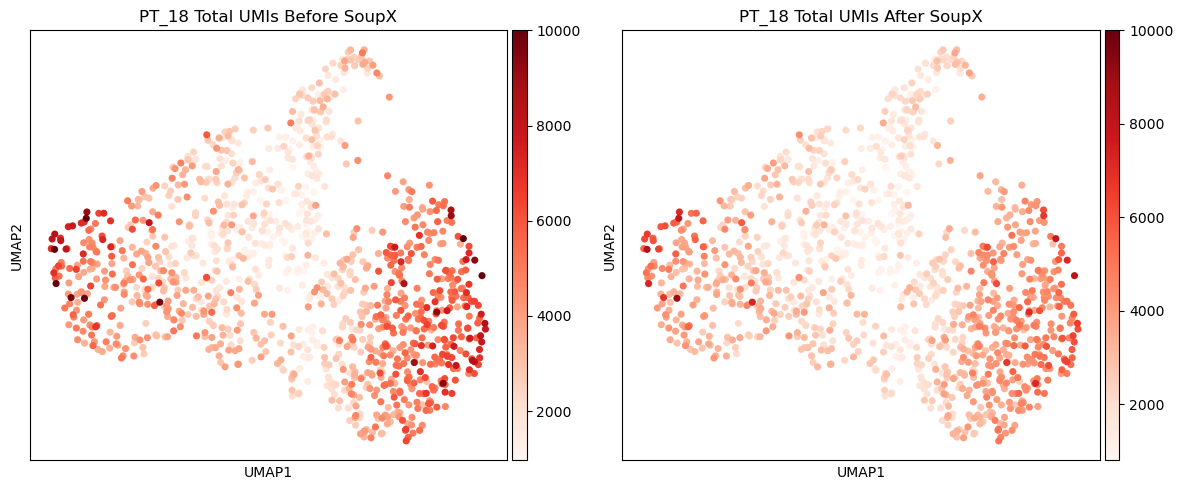

In [75]:
import numpy as np
import scanpy as sc
import matplotlib.pyplot as plt

# Calcular el total de UMIs por célula antes y después de la corrección con SoupX
adata_pt18.obs["Total UMIs Before"] = adata_pt18.layers["raw_counts"].sum(axis=1)
adata_pt18.obs["Total UMIs After"] = adata_pt18.layers["soupX_counts"].sum(axis=1)

# Crear figura con 2 UMAPs para visualizar el cambio de UMIs por célula con la misma escala
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# UMAP antes de SoupX (Total UMIs por célula, vmax=12000)
sc.pl.umap(adata_pt18, color="Total UMIs Before", ax=axes[0], show=False, cmap="Reds", vmax=10000)
axes[0].set_title("PT_18 Total UMIs Before SoupX")

# UMAP después de SoupX (Total UMIs por célula, vmax=12000)
sc.pl.umap(adata_pt18, color="Total UMIs After", ax=axes[1], show=False, cmap="Reds", vmax=10000)
axes[1].set_title("PT_18 Total UMIs After SoupX")

plt.tight_layout()
plt.show()

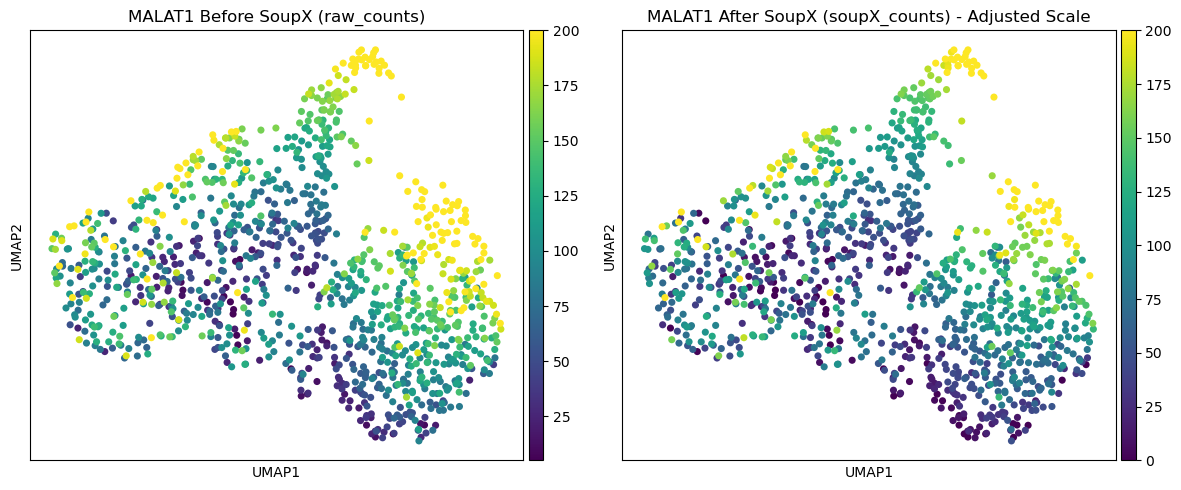

In [78]:
import scanpy as sc
import matplotlib.pyplot as plt

# Cargar el archivo PT_18 corregido con SoupX
adata_pt18 = sc.read_h5ad("/data/scratch/LAB/enric/Proyecto_pitagoras/Analisis_pitagoras/Results/01_matrices_corregidas_SoupX/PT_18_corrected_SoupX.h5ad")

# Verificar si el UMAP ya está calculado, si no, calcularlo
if "X_umap" not in adata_pt18.obsm:
    sc.pp.neighbors(adata_pt18, use_rep="X")
    sc.tl.umap(adata_pt18)

# Generar los UMAPs con escalas ajustadas
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# UMAP antes de SoupX (raw_counts) con vmax alto
sc.pl.umap(adata_pt18, color="MALAT1", layer="raw_counts", ax=axes[0], show=False, vmax=200)
axes[0].set_title("MALAT1 Before SoupX (raw_counts)")

# UMAP después de SoupX (soupX_counts) con vmax más bajo
sc.pl.umap(adata_pt18, color="MALAT1", layer="soupX_counts", ax=axes[1], show=False, vmax=200)
axes[1].set_title("MALAT1 After SoupX (soupX_counts) - Adjusted Scale")

plt.tight_layout()
plt.show()

